In [1]:
import json
import os
import girder_client
import large_image

import numpy as np
import matplotlib.pyplot as plt

# Need to pull things like API key from a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path=os.path.join('..', '.env'))

True

In [2]:
from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_bboxes_from_slide_annotations, # Grab a bounding box for each annotation in the slide
    parse_slide_annotations_into_tables, # Convert the annotation list into a pandas dataframe
    create_mask_from_coords, 
    get_image_from_htk_response # Given a girder response, get np array image
) 

C:\Users\jwfol\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
APIURL = 'http://199.109.192.21:8080/api/v1'

In [5]:
APIURL=os.getenv('APIURL')
print(APIURL)

http://199.109.192.21:8080/api/v1


In [4]:
# Use the dotenv library to get the API key
APIKEY=os.getenv('APIKEY')
print(APIKEY)

6dKeIszmD1TRI6P5ForTA327sOdV1V3l6UgGu5L0


In [5]:
APIKEY = '6dKeIszmD1TRI6P5ForTA327sOdV1V3l6UgGu5L0'

In [6]:
# Get the item ID from the Histomics server
COLLECTION_NAME = 'Oral Cavity Cancer'
FOLDER_NAME = 'WSI'
SAMPLE_NAME = 'OCC-01-0009-01Z-01-O01.tiff'

In [7]:
# Authenticate with the server
gc = girder_client.GirderClient(apiUrl=APIURL)
gc.authenticate(apiKey=APIKEY)

{'_id': '5e4af454b15faac00d35e5d2'}

In [8]:
collection_list = gc.listCollection()

In [9]:
for collection in collection_list:
    if collection['name'] == COLLECTION_NAME:
        collection_id = collection['_id']

In [10]:
folder_list = gc.listFolder(collection_id, parentFolderType='collection')

In [11]:
for folder in folder_list:
    if folder['name'] == FOLDER_NAME:
        folder_id = folder['_id']

In [12]:
item_list = gc.listItem(folder_id)

In [13]:
for item in item_list:
    if item['name'] == SAMPLE_NAME:
        sample_id = item['_id']

In [14]:
print(f"Sample Name:\t{SAMPLE_NAME}")
print(f"Image ID:\t{sample_id}")

Sample Name:	OCC-01-0009-01Z-01-O01.tiff
Image ID:	5e4af137e2ba484e10a750fd


In [15]:
# Grab the annotations associated with this item
slide_annotations = gc.get('/annotation/item/' + sample_id)

In [16]:
# Use the HistomicsTK utility functions to grab bounding boxes for each annotation
bboxes = get_bboxes_from_slide_annotations(slide_annotations)

In [17]:
# Create a Pandas dataframe with the annotations
annotation_table1, annotation_table2 = parse_slide_annotations_into_tables(slide_annotations)



In [18]:
annotation_table1.head()

,annotation_girder_id,_modelType,_version,itemId,created,creatorId,public,updated,updatedId,groups,element_count,element_details
0,5e540425203b28160ce79707,annotation,8434,5e4af137e2ba484e10a750fd,2020-02-24T17:13:09.891000+00:00,5e4ecc851e40bf148a464d0e,False,2020-03-16T17:41:07.675000+00:00,5e48a599d954392eb58f22af,[None],9,939
1,5e543599203b28160ce79713,annotation,446,5e4af137e2ba484e10a750fd,2020-02-24T20:44:09.566000+00:00,5e4ecc851e40bf148a464d0e,False,2020-02-24T20:45:17.391000+00:00,5e4ecc851e40bf148a464d0e,[],0,0


In [19]:
annotation_table2.head()

,annidx,annotation_girder_id,elementidx,element_girder_id,type,group,label,color,xmin,xmax,ymin,ymax,bbox_area,coords_x,coords_y
0,0,5e540425203b28160ce79707,0,f8675f76f389b5df7d8c0e21,polyline,NaN,NaN,"rgb(0,0,0)",69195,72719,119674,122239,9039060,"69195,69753,70713,72021,72719,72335,72231,7076...","120739,120686,119814,119674,120285,121158,1211..."
1,0,5e540425203b28160ce79707,1,d666e9cdad9e12463b448065,polyline,NaN,NaN,"rgb(0,0,0)",79541,83118,117110,119134,7239848,"81967,82071,82176,82246,82333,82403,82455,8257...","118453,118418,118348,118279,118244,118156,1180..."
2,0,5e540425203b28160ce79707,2,0eb55de8b780292d863eb9c4,polyline,NaN,NaN,"rgb(0,0,0)",77155,78777,115349,116106,1227854,"77950,77660,77520,77466,77439,77407,77343,7725...","115462,115515,115526,115526,115515,115510,1155..."
3,0,5e540425203b28160ce79707,3,73bc1b5160f07c498ff43839,polyline,NaN,NaN,"rgb(0,0,0)",78949,79733,115016,115628,479808,"79668,79625,79588,79534,79486,79453,79421,7933...","115016,115021,115032,115054,115080,115097,1151..."
4,0,5e540425203b28160ce79707,4,1f31b1c138e8691e91738351,polyline,NaN,NaN,"rgb(0,0,0)",79808,81886,114302,115940,3403764,"81247,81209,81166,81134,81102,81000,80968,8093...","114318,114329,114334,114339,114350,114372,1143..."


In [22]:
# Pick an annotation to work with
total_annotation = annotation_table2[annotation_table2.annidx == 0]

In [23]:
# The annotations for thyroid are 1 or more polylines with several points inside
# Separate into lines and polylines
annotation_line = total_annotation[total_annotation.type == 'polyline']
annotation_pts = total_annotation[total_annotation.type == 'point']

# Convert to non-series for the line (we assume a single polyline for this demo)
annotation_line = annotation_line.iloc[0,:]

In [24]:
# Get the bounding box and coordinates of this polyline, and parse into numbers
annotation_xmin = annotation_line['xmin']-5
annotation_ymin = annotation_line['ymin']-5
annotation_xmax = annotation_line['xmax']
annotation_ymax = annotation_line['ymax']
annotation_width = annotation_line['xmax'] - annotation_line['xmin'] + 5
annotation_height = annotation_line['ymax'] - annotation_line['ymin'] + 5

coords_x = [np.int(x)-annotation_xmin for x in annotation_line['coords_x'].split(',')]
coords_y = [np.int(y)-annotation_ymin for y in annotation_line['coords_y'].split(',')]

# Add the first point to the end, to "close" the polygon
coords_x.append(coords_x[0])
coords_y.append(coords_y[0])

In [25]:
getStr = f"item/{sample_id}/tiles/region?"+ \
    f"left={annotation_xmin}&"+ \
    f"right={annotation_xmax}&"+ \
    f"top={annotation_ymin}&"+ \
    f"bottom={annotation_ymax}"

resp = gc.get(getStr, jsonResp=False)
img_roi = get_image_from_htk_response(resp)



In [26]:
# Cycle through each point and grab it
pts_x = np.array(annotation_pts.xmin) - annotation_xmin
pts_y = np.array(annotation_pts.ymin) - annotation_ymin

num_pts = len(pts_x)

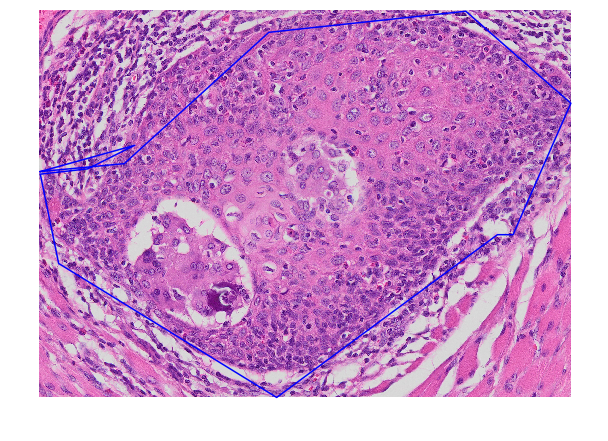

In [27]:
# Display the polyline plus the points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(img_roi)
ax.plot(coords_x, coords_y, c='b')
ax.scatter(pts_x, pts_y, c='g')
ax.axis('off')
plt.show()


In [28]:
# Run the Voronoi diagram on the points
from scipy.spatial import Voronoi, voronoi_plot_2d

pts = []
for idx in range(num_pts):
    pts.append([pts_x[idx], pts_y[idx]])

bounds = []
for idx in range(len(coords_x)):
    bounds.append([coords_x[idx], coords_y[idx]])

# # Optionally, you can use the polyline coordinates as part of the Voronoi
# for idx in range(len(coords_x)):
#     pts.append([coords_x[idx], coords_y[idx]])

In [29]:
# Create the tesselation
vor = Voronoi(pts)

IndexError: tuple index out of range

NameError: name 'vor' is not defined

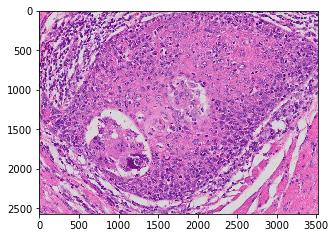

In [30]:
# Display the image + Voronoi
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(img_roi)
voronoi_plot_2d(vor, point_size=10, ax=ax)
ax.plot(coords_x, coords_y, c='b')
ax.axis('off')
plt.show()

In [31]:
img_mask = create_mask_from_coords(np.array(bounds))

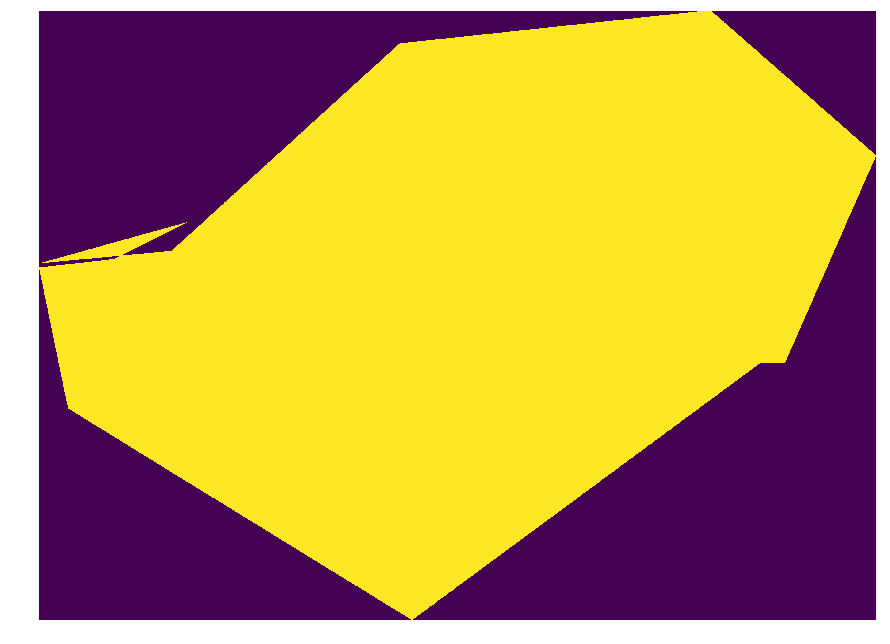

In [32]:
# Display the image + Voronoi
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(img_mask)
ax.axis('off')
plt.show()

In [33]:
from skimage.morphology import skeletonize

In [34]:
img_skel = skeletonize(img_mask)

In [ ]:
# Display the image + Voronoi
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(img_skel)
ax.axis('off')
plt.show()

In [ ]:
from scipy import ndimage

img_edt = ndimage.distance_transform_edt(img_mask)

In [ ]:
# Display the image + Voronoi
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(img_edt)

ax.axis('off')
plt.show()

In [ ]:
skel_ravel = np.ravel(img_skel)
edt_ravel = np.ravel(img_edt)

In [ ]:
edt_ridge = edt_ravel[skel_ravel]

In [ ]:
# Display the image + Voronoi
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(edt_ridge)
plt.show()

In [ ]:
maj_axis_length = np.mean(edt_ridge*2)
min_axis_length = np.sum(img_skel) / num_pts

In [ ]:
print(f"Major axis length (avg): {maj_axis_length}")
print(f"Minor axis length (avg): {min_axis_length}")
print(f"Minor-to-Major axis ratio: {min_axis_length / maj_axis_length}")